# Problem 6: Simple Bayesian Regression With Stan

For this exercise, you will write a probabilistic program in Stan that can sample from the posterior
p(α, β | D) of a simple (linear) Bayesian regression given a data set D = {xn, yn}
N
n=1. The program
3
should represent the following generative specification:



$$
\sigma^2 \sim \text{Inv-Gamma(1,1)}
$$ 

$$
\alpha \sim \mathcal{N}(0, 10)
$$

$$
\beta \sim \mathcal{N}(0, 10)
$$

$$
y_n \sim \mathcal{N}(\alpha + \beta\,x_{n}, \sigma^2)\quad\text{for}\quad n = 1,\dots,N
$$

which essentially encodes the assumption that an outcome y is predicted from a covariate x via:


$$
y_n = \alpha + \beta\,x_{n} + \epsilon_n \quad\text{with }  \epsilon _n \sim \mathcal{N}(0, \sigma^2)
$$

First, simulate a data set with fixed intercept (α), slope (β), and noise (σ) parameters of your
choosing, as well as a pre-set number of observations N. For instance, your simulation could look
something like this:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

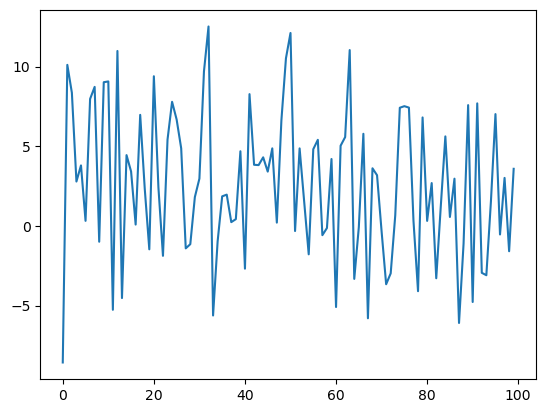

In [8]:
N = 100
alpha = 2.3
sigma = 2.
slope = 4. # Beta
x = np.random.normal(size=N)
y = alpha + slope * x + sigma * np.random.normal(size=N)
plt.plot(y)


### Create Stan-friendly data dictionary
data = {
    'N': N,
    'x': x,
    'y': y
}

In [13]:
# Realization in STAN

sbr_stan_code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}


model {
  sigma2 ~ inv_gamma(1, 1);
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  y ~ normal(alpha + beta * x, sigma2);
}
"""

In [14]:
vectorized_posterior = stan.build(sbr_stan_code, data=data)

Building...



Building: 27.0s, done.

In [15]:
%%time
fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!


CPU times: user 281 ms, sys: 625 ms, total: 906 ms
Wall time: 1.17 s


In [18]:
df = fit_vectorized.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma2,sigma
draws,,,,,,,,,,,
0,-117.927833,0.994830,0.947370,2.0,7.0,0.0,120.775972,2.197573,4.138594,1.856590,1.362567
1,-118.137956,0.890993,0.744783,3.0,7.0,0.0,119.841755,2.107921,4.228838,1.845809,1.358605
2,-119.283701,0.920392,0.774761,2.0,3.0,0.0,120.315151,2.336470,4.442554,2.007524,1.416871
3,-122.746155,0.797949,0.676677,3.0,7.0,0.0,125.302002,2.093067,4.349168,1.602611,1.265943
4,-118.777270,0.906504,0.947370,2.0,3.0,0.0,118.935900,2.459560,4.076981,2.005923,1.416306


In [19]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.188,0.196,1.831,2.559,0.002,0.002,6282.0,5649.0,1.0
beta,4.157,0.198,3.773,4.513,0.002,0.002,6954.0,4742.0,1.0
sigma2,1.975,0.142,1.725,2.250,0.002,0.001,7664.0,5589.0,1.0
sigma,1.405,0.050,1.315,1.501,0.001,0.000,7664.0,5589.0,1.0


/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


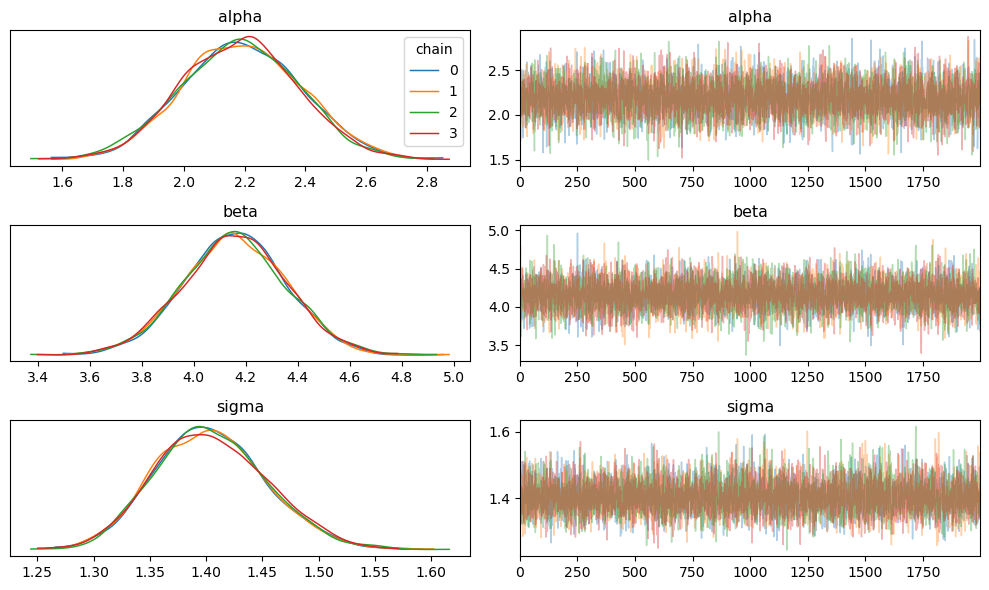

In [21]:
axarr = az.plot_trace(fit_vectorized, var_names=['alpha', 'beta', 'sigma'], figsize=(10, 6), compact=False, legend=True)
plt.tight_layout()

### Inspection:

The convergence and efficiency diagnostics numerically show strong support for convergence - this can be seen by several factors. First, that $\hat{r}$ for each parameter is equal to 1 (this shows convergence - if $\hat{r}$ is not 1, then convergence has not been reached). Second, the small standard deviation and HDI  are low, indicating strong convergence and accuracy/precision. Visually, each chain has significant overlap, supporting the convergence conclusion with low uncertainty.


**Alpha:**

In an analysis of Alpha, the posterior mean is 2.188, which is close to the actual value, and the standard deviation is 0.196. The actual value is 2.3, which 94 percent HDI encompasses, with it being from 1.831 to 2.559.

**Beta:**

In an analysis of Beta, the posterior mean is 4.157, which is close to the actual value, and the standard deviation is 0.198. The actual value is four, which 94 percent HDI encompasses, with it being from 3.773	to 4.513.


**Sigma:**

In analysis of Alpha, the posterior mean is 1.975 which is close to the actual value and the standard deviation is 0.142. The actual value is 2.0 which 94 HDI encompasses with it being from 1.1.725	to 2.250.

Given the analysis above, it can be concluded that the uncertainty left is minimal.

### Repeat the analysis with ten times as many observations and report what happens to the precision and uncertainty (2 points).

Building...



Building: found in cache, done.Sampling:   0%


Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling:  79% (9500/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00026 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000246 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000277 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000302 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Except

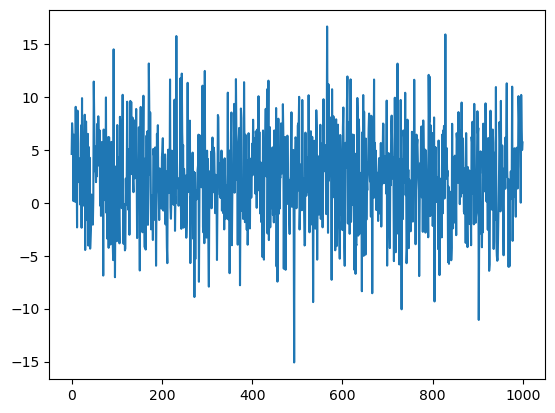

In [28]:
N = 100 * 10
alpha = 2.3
sigma = 2.
slope = 4. # Beta
x = np.random.normal(size=N)
y = alpha + slope * x + sigma * np.random.normal(size=N)
plt.plot(y)


### Create Stan-friendly data dictionary
data = {
    'N': N,
    'x': x,
    'y': y
}

vectorized_posterior = stan.build(sbr_stan_code, data=data)
fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

In [29]:
df = fit_vectorized.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma2,sigma
draws,,,,,,,,,,,
0,-1218.666574,0.997722,0.871764,2.0,3.0,0.0,1219.285620,2.339016,3.845430,2.050586,1.431987
1,-1218.454304,0.998690,0.795682,3.0,7.0,0.0,1220.260485,2.323576,3.962830,2.071526,1.439280
2,-1219.040412,0.887028,0.755170,3.0,7.0,0.0,1220.760188,2.392503,3.906840,1.992197,1.411452
3,-1220.922475,0.795512,0.713244,3.0,7.0,0.0,1221.221504,2.362726,3.920465,1.942291,1.393661
4,-1218.839052,0.967310,0.871764,2.0,3.0,0.0,1219.221346,2.312566,3.993228,2.037451,1.427393


In [30]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.349,0.065,2.227,2.467,0.001,0.001,8088.0,6042.0,1.0
beta,3.920,0.067,3.801,4.050,0.001,0.001,7876.0,5814.0,1.0
sigma2,2.051,0.046,1.969,2.141,0.001,0.000,8166.0,6082.0,1.0
sigma,1.432,0.016,1.403,1.463,0.000,0.000,8166.0,6082.0,1.0


/home/matt/miniconda3/envs/cognitive/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


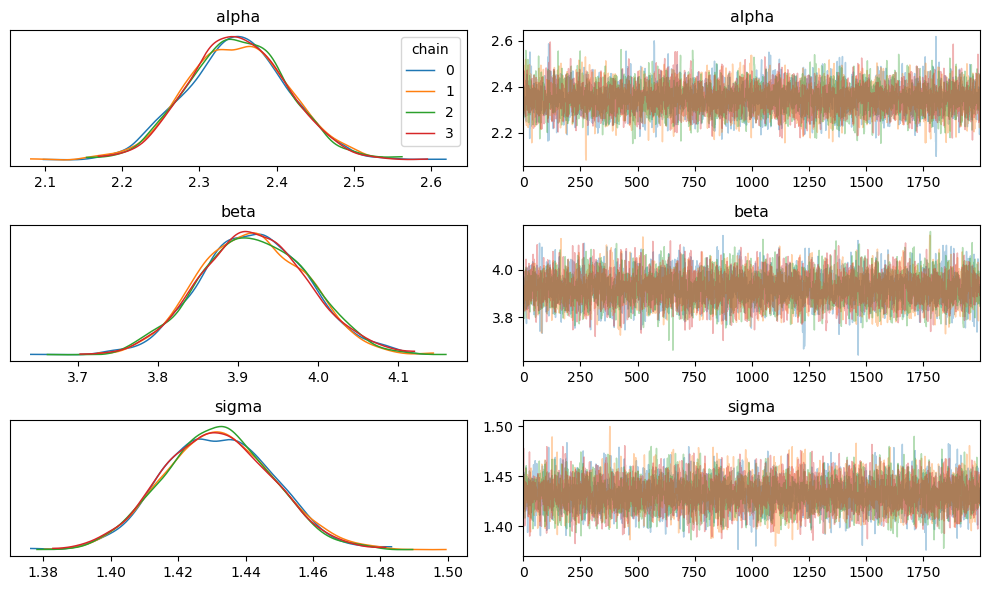

In [31]:
axarr = az.plot_trace(fit_vectorized, var_names=['alpha', 'beta', 'sigma'], figsize=(10, 6), compact=False, legend=True)
plt.tight_layout()

### Ten times as many observations Analysis:

Both numerically and graphically, the evidence supports that accuracy and precision increase as the amount of sample taken increases. We cane verify this numerically by observing the smaller range of values for 94 percent HDI. We also see that the standard deviation significantly decreases for each parameter as well, in addition to the mean of each being slightly closer to the true value.